# MultiLayer Perceptron

Como primeiro modelo do nosso trabalho iremos implementar uma Feedforward Neural Network.<br>
Uma Feedforward Neural Network (FNN) é um tipo de Artifical Neural Network (ANN) onde conexões entre nodes não formam ciclos, isto é, a informação flui numa única direção, desde a input layer até à output layer.<br>
Uma Multilayer Perceptron (MLP) é um tipo de FNN, onde existe pelo menos uma hidden layer (rede de neurónios que transformam os dados que lhes são dados, através de weights, biases e activation functions).<br>
A nossa MLP será mais detalhadamente analisada quando a criarmos.

Este notebook está dividido nas seguinte partes:
- 0. Libraries
- 1. Notas Iniciais
- 2. Preparação do Audio, Extração, Pre-Processamento e Checkpoint
- 3. Criação do Modelo
- 4. 10-Fold Cross Validation e Hypertuning
- 5. Análise dos Resultados
- 6. Conclusões

# 

# 0. Libraries

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import librosa as lr

import keras
import tensorflow as tf
from keras import optimizers
from keras import regularizers
from keras import models, layers
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate, LeakyReLU

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2024-12-02 17:29:35.723783: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 17:29:35.724932: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 17:29:35.727752: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 17:29:35.733930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733160575.745344    3605 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733160575.74

# 

# 1. Notas Iniciais

Como já foi mencionado no primeiro notebook, este modelo é mais orientado para manuseamento de dados em 1D, uma vez que não tem capacidade de deteção de padrões espaciais/temporais em grandes distâncias.<br>
Assim sendo, a nossa primeira abordagem foi o desenvolvimento de um modelo que recebia como input apenas e só features 1D. Para este primeiro modelo, foram escolhidas as Spectral Features de uma dimensão. Infelizmente, mesmo com um modelo bastante complexo, os resultados eram um pouco pobres, nunca ultrapassando uma testing accuracy de 40%.

A nossa segunda abordagem serviu para analisar os resultados do modelo quando sujeito a inputs originalmente de duas dimensões. Tendo como base o PDF recomendado, bem como a esmagadora maioria dos trabalhos realizado e fornecidos online, utilizamos como input a média de 40 MFCCs durante a duração do audio, obtendo um input 1D de shape (40,).<br>
Surpreendentemente, a performance deste modelo ultrapassou a performance do nosso primeiro modelo, mas nunca passando dos 45% de accuracy no testing set. Todavia, achamos este resultado um pouco mediocre, e decidimos fazer uma melhorias.

Chegamos, portanto, ao nosso terceiro modelo, que resultou da combinação dos nossos dois primeiro modelos. Para nosso agrado este modelo revelou uma melhoria, embora leve.<br>
Numa final (e desesperada) tentativa de melhorar o nosso modelo, substituímos a média das bandas MFCCs pela média dos valores do Mel Spectrogram, e adicionamos a média dos valores do Chromagram. Estas adições tiveram por base recomendações de colegas e a conclusão de que estas seriam as features mais informativas para o nosso modelo.

O input deste modelo final é, portanto, constituido por 6 features, todas elas unidimensionais! Temos:
- Mel Spectrogram (média);
- Chromagram (média);
- Spectral Centroid;
- Spectral Bandwidth;
- Spectral Flatness;
- Spectral Rolloff.

# 

# 2. Preparação do Audio, Extração, Pre-Processamento e Checkpoint

O nosso modelo tem de receber como input uma série de arrays com tamanho fixo. Ora aqui nos deparamos com o nosso primeiro problema. Tal como mencionado no ponto 3.1 do PDF das direções para o projeto, os ficheiros de audio podem ter durações e sampling rates (quantidade de audio samples capturadas por segundo) diferentes. Isto significa que, para audio diferentes, as mesmas extrações vão ter tamanhos diferentes. De forma a combater este problema iremos, neste passo, realizar a **uniformização** destes aspetos!

Para duração do audio iremos utilizar um **tamanho fixo de 4 segundos**. Audios com duração menor serão padded com zeros, enquanto que audios com maior duração serão truncados.
Quanto à sampling rate, poderiamos escolher valores como 16000Hz (qualidade comum), 22050Hz (qualidade melhorada) ou 44100Hz (CD-Quality). Uma vez que a maioria dos ficheiros têm uma **sample rate de 22050HZ**, e esta é a qualidade com maior fidelidade, optaremos por esta sampling rate.

Temos mais uns valores que convém fixar!<br>
A window length representa o número de audio samples analisadas de cada vez, e fixamos um valor de 507 samples (23ms).<br>
A hop length representa quanto a window lentgh se move após cada step, e foi fixado um valor de 276 samples (12.5ms). Este valor, menor que a window length, permite um ligeiro overlap de samples, resultando numa melhor resolução e melhor análise. Ótimo!<br>
Por fim, quanto ao número de pontos usados no Fast Fourier Transform define a resolução dos espectrogramas (no nosso caso, Mel-Spectrogram). Fixamos este valor a 2¹⁰ (1024), tornando esta extração bem definida mas não demasiado custosa.

Falando agora do nosso método de extração. Iremos começar por iterar por cada fold e, dentro de cada iteração, iteraremos também por cada ficheiro de audio. Para cada ficheiro iremos proceder à uniformização mencionada em cima, seguido da extração das features e consequente normalização! Segue-se a criação de um dicionário para cada audio, que guarda a fold a que pertence, as suas features, e a sua classe. Este dicionário é adicionado a uma lista que, no fim de todas as extrações, é transformado em DataFrame. O nosso último passo é o one hot encoding das labels, transformando um número categórico (de 0 a 9) num array (também de 0 a 9)!

É de **extrema importância** salientar que este processo é **muito demorado** e **computacionalmente dispendioso**.<br>
De modo a não ter de fazer a extração das features sempre que queremos trabalhar neste notebook, optamos por guardar o dataframe em formato pickle, estabelecendo assim um "checkpoint"! Assim, antes de realizar a extração, será verificada a existência do dataframe no diretório atual. Este será loaded se existir, caso contrário, realizar-se-á a extração!

In [2]:
#definir path do ficheiro com metadata
metadata_path = "/home/miguel/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv"
metadata_df = pd.read_csv(metadata_path)

#definir localizacao da pasta que contem os folds com os ficheiros audio
dir_folds = "/home/miguel/sound_datasets/urbansound8k/audio"

In [3]:
#lista para guardar o nosso dataframe
dados = []

#lista com o nome das pastas dos folds
folds = [fold for fold in os.listdir(dir_folds) if "fold" in fold]

#definicao do nosso normalizador
scaler = MinMaxScaler()

In [4]:
#se a extração já foi feita
if os.path.exists(os.path.join(os.getcwd(), "extracoes_mlp.pkl")):
    
    #abrir o dataframe em formato pickle
    with open(os.path.join(os.getcwd(), "extracoes_mlp.pkl"), "rb") as ficheiro:
        dados = pickle.load(ficheiro)
    ficheiro.close()
    
    
    
#se ainda não foi feita extração   
else:
    
    #para cada fold
    for fold in folds:
    
        #determinar o path de cada audio na fold
        audio_files = lr.util.find_files(os.path.join(dir_folds,fold))

        #para cada audio da fold
        for audio in audio_files:
            
            #obter a sua classe
            classid = metadata_df[metadata_df["slice_file_name"]==audio.split('/')[-1]]["classID"].values[0]

            #obter o audio e sample rate
            y, sample_rate = lr.load(audio, sr=None)
            
            #resample do audio com a sample rate definida 
            y = lr.resample(y, orig_sr=sample_rate, target_sr=22050)

            #caso a duracao seja menor que a definida, adicionar silencio no fim
            if len(y) < 4*22050:
                y = np.concatenate([y, np.zeros(shape=(4*22050 - len(y),))])
            #caso a duracao seja maior que a definida, truncar o audio
            elif len(y) > 4*22050:
                y = y[:4*22050]

            #extrair Mel-Spectrogram com os valores definidos, fazendo a sua média
            melspectrogram = lr.feature.melspectrogram(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            melspectrogram = lr.power_to_db(melspectrogram, ref=np.max)
            melspectrogram = np.mean(melspectrogram.T, axis=0)
            melspectrogram = melspectrogram.reshape(-1, 1)
            melspectrogram = scaler.fit_transform(melspectrogram)
            melspectrogram = melspectrogram.flatten()

            #extrair Chromagram com os valores definidos, fazendo a sua média
            chromagram = lr.feature.chroma_stft(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023), n_chroma=121)
            chromagram = np.mean(chromagram.T, axis=0)
            chromagram = chromagram.reshape(-1, 1)
            chromagram = scaler.fit_transform(chromagram)
            chromagram = chromagram.flatten()

            #extrair Spectral Centroid com os valores definidos
            centroid = lr.feature.spectral_centroid(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            centroid = centroid.reshape(-1, 1)
            centroid = scaler.fit_transform(centroid)
            centroid = centroid.flatten()
            
            #extrair Spectral Bandwidth com os valores definidos
            bandwidth = lr.feature.spectral_bandwidth(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            bandwidth = bandwidth.reshape(-1, 1)
            bandwidth = scaler.fit_transform(bandwidth)
            bandwidth = bandwidth.flatten()

            #extrair Spectral Flagtness com os valores definidos
            flatness = lr.feature.spectral_flatness(y=y, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            flatness = flatness.reshape(-1, 1)
            flatness = scaler.fit_transform(flatness)
            flatness = flatness.flatten()
            
            #extrair Spectral Rolloff com os valores definidos
            rolloff = lr.feature.spectral_rolloff(y=y, sr=22050, n_fft=2**10, hop_length=round(22050 * 0.0125), win_length=round(22050 * 0.023))
            rolloff = rolloff.reshape(-1, 1)
            rolloff = scaler.fit_transform(rolloff)
            rolloff = rolloff.flatten()
            
            #dicionario com as extracoes do audio
            extract = {"fold": fold, "melspectrogram": melspectrogram, "chromagram": chromagram , "spectral_centroid": centroid, "spectral_bandwidth": bandwidth, "spectral_flatness": flatness, "spectral_rolloff": rolloff, "label": int(classid)}

            #juntar extracoes do audio à lista de extracoes totais
            dados.append(extract)
        
    #transformar lista em dataframe
    dados = pd.DataFrame(dados, columns=["fold", "melspectrogram", "chromagram", "spectral_centroid", "spectral_bandwidth", "spectral_flatness", "spectral_rolloff", "label"])

    #one hot encoding das labels
    encoded_labels = np.zeros(shape=(dados['label'].size, dados['label'].max()+1))
    encoded_labels[np.arange(dados['label'].size),dados['label'].to_numpy(dtype=np.int16)] = 1
    dados['label'] = encoded_labels.tolist()
    dados['label'].apply(np.array)

    #guardar ficheiro (checkpoint :3)
    with open(os.path.join(os.getcwd(), "extracoes_mlp.pkl"), "wb") as ficheiro:
        pickle.dump(dados, ficheiro)
    ficheiro.close()

In [5]:
dados.head()

,fold,melspectrogram,chromagram,spectral_centroid,spectral_bandwidth,spectral_flatness,spectral_rolloff,label
0,fold4,"[0.806506644268927, 0.8219500968111428, 0.8220...","[0.47617793730570024, 0.4978262052225948, 0.52...","[0.710724007124062, 0.7390557281201223, 0.7593...","[0.7832721329550927, 0.7985541430059526, 0.789...","[0.04231299245865143, 0.026747778059695835, 0....","[0.6435045317220545, 0.6404833836858006, 0.679...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,fold4,"[0.7630074, 0.7953318, 0.79741013, 0.77455187,...","[0.07691419, 0.06661734, 0.057540387, 0.048308...","[0.20944643294219423, 0.32460744543622655, 0.4...","[0.31478213540004907, 0.5819808414209833, 0.65...","[0.4239146, 0.43703368, 0.4373747, 0.4178115, ...","[0.19999999999999996, 0.3935483870967742, 0.46...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,fold4,"[0.9619512, 1.0, 0.9944292, 0.957806, 0.907686...","[0.18565702, 0.1466887, 0.11952758, 0.08807099...","[0.07174267797810696, 0.2614667876438652, 0.42...","[0.21490444345586557, 0.4127702128089261, 0.56...","[0.08502611, 0.07318882, 0.11317568, 0.1435704...","[0.13567839195979903, 0.24623115577889454, 0.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,fold4,"[0.734753, 0.7764771, 0.7896387, 0.7699456, 0....","[0.0119020045, 0.011307061, 0.009559631, 0.006...","[0.4495995690142345, 0.6381866566483938, 0.621...","[0.627986308924747, 0.5531523552432991, 0.5443...","[0.2277407, 0.11402608, 0.16706528, 0.15765731...","[0.4397905759162304, 0.48167539267015713, 0.49...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,fold4,"[0.9419676, 0.9964842, 1.0, 0.95660645, 0.8874...","[0.33912838, 0.26733482, 0.23282433, 0.1845579...","[0.3207800009544466, 0.3562599351698317, 0.166...","[0.33465793801065447, 0.2511552936389183, 0.28...","[0.5059185, 0.24970384, 0.038606435, 0.2269723...","[0.39743589743589736, 0.3846153846153846, 0.38...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 

# 3. Criação do Modelo

Vamos agora criar a nossa FNN. Este modelo será constituido de fully connected (dense) layers, tornando-o essencialmente um MLP!<br>
Temos:

- **Input Layer**: a nossa primeira camada é constituída por 6 inputs de uma dimensão cada. O primeiro input é o melspectrogram e tem shape (128,), o segundo input é o chromagram e tem shape (121,), os restantes 4 inputs são as spectral features e têm todas shape (320,).


- **Hidden Layers**: para estas camadas foi fixado um valor de 30% de **_dropout_** para prevenir overfitting ("desativa" 30% dos neurónios da camada para prevenir que o modelo dependa muito de certos neurónios); foi fixado o tipo de **_activation function_** LeakyReLU com alpha=0.1 (uma melhoria de ReLU, retorna "alpha * x", sendo alpha um valor muito pequeno, se x é negativo; e retorna x se x é positivo) uma vez que é uma função eficiente e previne a "morte" de neurónios se receberem muitos valores negativos ou zeros seguidos; e foi também fixado um valor de 0.001 para **_L2 regularization_**, essencialmente prevenindo overfit através do impedimento da atribuição de pesos muito elevados.<br>Para cada tipo de input definimos um método de processamento diferente.<br>Nas **_spectral features_**, a sua **_primeira camada é constituída por 512 neurónios_**, passando depois pela **_função de ativação e um dropout_**. Este processo **_repete-se mais três vezes_**, sendo o **_número de neurónios para cada camada alterado para 256, 128 e 32_**, respetivamente.<br>Para o **_melspectrogram e chromagram_**, o número de camadas diminui para **_3 dense layers (com consequente ativação e dropout)_**, sendo o número de **_neurónios 128, 256 e 128 para cada respetiva layer_**.<br>Por fim, é tudo **_concatenado, passado a uma camada de 256 neurónios que depois é normalizada e passa por uma ativação e um dropout_**, alimentando o resultado à nossa última camada, com 64 neurónios e a última função de ativação.


- **Output Layer**: esta camada tem os 10 neurónios finais, cada um representando uma classe. Usamos a activation function softmax (retorna a probabilidade do audio ser de cada uma das classes, e escolhe a classe com probabilidade mais elevada).

In [6]:
print(f"Shape Mel-Spectrogram: {dados.iloc[0,1].shape}")
print(f"Shape Chromagram: {dados.iloc[0,2].shape}")
print(f"Shape Spectral Centroid: {dados.iloc[0,3].shape}")
print(f"Shape Spectral Bandwidth: {dados.iloc[0,4].shape}")
print(f"Shape Spectral Flatness: {dados.iloc[0,5].shape}")
print(f"Shape Spectral Rolloff: {dados.iloc[0,6].shape}")

Shape Mel-Spectrogram: (128,)
Shape Chromagram: (121,)
Shape Spectral Centroid: (320,)
Shape Spectral Bandwidth: (320,)
Shape Spectral Flatness: (320,)
Shape Spectral Rolloff: (320,)


In [7]:
#dimensoes de cada input
dim_melspectrogram=(128,)
dim_chromagram=(121,)
dim_spectrals=(320,)

In [8]:
#funcao para criar o modelo (usada a cada iteracao do 10-fold cross validation)
def create_model():
    
    #definicao de 5 inputs diferentes
    input1 = Input(shape=dim_melspectrogram, name='melspectrogram')
    input2 = Input(shape=dim_chromagram, name='chromagram')
    input3 = Input(shape=dim_spectrals, name='spectral_centroid')  
    input4 = Input(shape=dim_spectrals, name='spectral_bandwidth')  
    input5 = Input(shape=dim_spectrals, name='spectral_flatness')  
    input6 = Input(shape=dim_spectrals, name='spectral_rolloff') 

    #processamento melspectrogram
    x1 = Dense(128, kernel_regularizer=l2(0.001))(input1)
    x1 = LeakyReLU(negative_slope=0.1)(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(256, kernel_regularizer=l2(0.001))(x1)
    x1 = LeakyReLU(negative_slope=0.1)(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(128, kernel_regularizer=l2(0.001))(x1)
    x1 = LeakyReLU(negative_slope=0.1)(x1)
    x1 = Dropout(0.3)(x1)
    
    #processamento chromagram
    x2 = Dense(128, kernel_regularizer=l2(0.001))(input2)
    x2 = LeakyReLU(negative_slope=0.1)(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(256, kernel_regularizer=l2(0.001))(x2)
    x2 = LeakyReLU(negative_slope=0.1)(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(128, kernel_regularizer=l2(0.001))(x2)
    x2 = LeakyReLU(negative_slope=0.1)(x2)
    x2 = Dropout(0.3)(x2)
    
    #processamento spectral centroid
    x3 = Dense(512, kernel_regularizer=l2(0.001))(input3)
    x3 = LeakyReLU(negative_slope=0.1)(x3)
    x3 = Dropout(0.3)(x3)
    x3 = Dense(256, kernel_regularizer=l2(0.001))(x3)
    x3 = LeakyReLU(negative_slope=0.1)(x3)
    x3 = Dropout(0.3)(x3)
    x3 = Dense(128, kernel_regularizer=l2(0.001))(x3)
    x3 = LeakyReLU(negative_slope=0.1)(x3)
    x3 = Dropout(0.3)(x3)
    x3 = Dense(32, kernel_regularizer=l2(0.001))(x3)
    x3 = LeakyReLU(negative_slope=0.1)(x3)
    x3 = Dropout(0.3)(x3)
    
    
    #processamneto spectral bandwidth
    x4 = Dense(512, kernel_regularizer=l2(0.001))(input4)
    x4 = LeakyReLU(negative_slope=0.1)(x4)
    x4 = Dropout(0.3)(x4)
    x4 = Dense(256, kernel_regularizer=l2(0.001))(x4)
    x4 = LeakyReLU(negative_slope=0.1)(x4)
    x4 = Dropout(0.3)(x4)
    x4 = Dense(128, kernel_regularizer=l2(0.001))(x4)
    x4 = LeakyReLU(negative_slope=0.1)(x4)
    x4 = Dropout(0.3)(x4)
    x4 = Dense(32, kernel_regularizer=l2(0.001))(x4)
    x4 = LeakyReLU(negative_slope=0.1)(x4)
    x4 = Dropout(0.3)(x4)
    
    #processamento spectral flatness
    x5 = Dense(512, kernel_regularizer=l2(0.001))(input5)
    x5 = LeakyReLU(negative_slope=0.1)(x5)
    x5 = Dropout(0.3)(x5)
    x5 = Dense(256, kernel_regularizer=l2(0.001))(x5)
    x5 = LeakyReLU(negative_slope=0.1)(x5)
    x5 = Dropout(0.3)(x5)
    x5 = Dense(128, kernel_regularizer=l2(0.001))(x5)
    x5 = LeakyReLU(negative_slope=0.1)(x5)
    x5 = Dropout(0.3)(x5)
    x5 = Dense(32, kernel_regularizer=l2(0.001))(x5)
    x5 = LeakyReLU(negative_slope=0.1)(x5)
    x5 = Dropout(0.3)(x5)
    
    #processamento spectral roloff
    x6 = Dense(512, kernel_regularizer=l2(0.001))(input6)
    x6 = LeakyReLU(negative_slope=0.1)(x6)
    x6 = Dropout(0.3)(x6)
    x6 = Dense(256, kernel_regularizer=l2(0.001))(x6)
    x6 = LeakyReLU(negative_slope=0.1)(x6)
    x6 = Dropout(0.3)(x6)
    x6 = Dense(128, kernel_regularizer=l2(0.001))(x6)
    x6 = LeakyReLU(negative_slope=0.1)(x6)
    x6 = Dropout(0.3)(x6)
    x6 = Dense(32, kernel_regularizer=l2(0.001))(x6)
    x6 = LeakyReLU(negative_slope=0.1)(x6)
    x6 = Dropout(0.3)(x6)

    

    #concatenacao de todos os inputs processados
    merged = concatenate([x1, x2, x3, x4, x5, x6])

    #camadas finais após concatenação
    fc = Dense(256, kernel_regularizer=l2(0.001))(merged)
    fc = BatchNormalization()(fc)
    fc = LeakyReLU(negative_slope=0.01)(fc)
    fc = Dropout(0.3)(fc)
    fc = Dense(64, kernel_regularizer=l2(0.001))(fc)
    fc = LeakyReLU(negative_slope=0.01)(fc)

    
    #output
    output = Dense(10, activation='softmax')(fc)  

    
    #definição do modelo
    model = Model(inputs=[input1, input2, input3, input4, input5, input6], outputs=output)
    
    
    #return
    return model

In [9]:
#criar modelo exemplar
model = create_model()

2024-12-02 17:29:37.290121: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
#sumário do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectral_centroid   │ (None, 320)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_bandwidth  │ (None, 320)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_flatness   │ (None, 320)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_rolloff    │ (None, 320)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    164,352 │ spectral_centroi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    164,352 │ spectral_bandwid… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │    164,352 │ spectral_flatnes… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │    164,352 │ spectral_rolloff… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 512)       │          0 │ dense_6[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 512)       │          0 │ dense_10[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_14      │ (None, 512)       │          0 │ dense_14[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 512)       │          0 │ dense_18[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ melspectrogram      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chromagram          │ (None, 121)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 512)       │          0 │ leaky_re_lu_10[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 512)       │          0 │ leaky_re_lu_14[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 512)       │          0 │ leaky_re_lu_18[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,611,466 (6.15 MB)

 Trainable params: 1,610,954 (6.15 MB)

 Non-trainable params: 512 (2.00 KB)

In [11]:
#esquema geral do modelo
keras.utils.plot_model(model, "model.png", show_shapes=True)

Resumindo o nosso modelo:<br>
- Pipelines separadas para cada input;
- Função de ativação LeakyReLU;
- Regularização com uso de Dropout constante a 30% e L2 a 0.001;
- Concatenação dos inputs depois de processados;
- Normalização dos inputs concatenados com BatchNormalization;
- Total de 1,611,466 parâmetros, dos quais 1,610,954 são treináveis (weights e biases) e 512 não são treináveis (kernel_regularizer, negative_slope, dropout, ...).

De um modo geral, temos um modelo complexo e prontíssimo para ser treinado :)

# 

# 4. 10-Fold Cross Validation e Hypertuning

Chegou a hora de testar o nosso modelo!<br>
Iremos, para cada fold, usar a fold como test e as restantes como train e validação (20% do train). Vamos recolher informações sobre o comportmento do nosso modelo (accuracy, loss, previsoes, ...) para depois analisarmos o modelo no próximo passo.


Esta parte do trabaho serviu também para descobrir a melhor combinação de hiperparâmetros.<br>
Fizemos testes com:
- **Optimizer** (acabamos por selecionar o **adam**, que nos garantiu melhores resultados);
- **Learning Rate** (definida para **0.001** inicialmente, sendo depois adaptada pelo optimizer);
- **Epochs** (estabelecemos um máximo de **500 epochs**, uma vez que o MLP tem várias limitações e, deste modo, permitimos o modelo aprender muito);
- **Early Stopping** (se o modelo não detetar melhorias na **validation loss** passado **100 epochs**, o treino é parado, mas nunca prematuramente pois permite a execução de no mínimo 100 epochs);
- **Weight Regularization** (além da L2 regularization implementada no desenvolvimento do modelo, temos também definido que após a paragem do treino, os **pesos com melhores resultados NÃO são restaurados**; esta escolha foi tomada pois foram implementadas bastantes medidas contra overfit, tal como L2 regularization e dropout, e assim permitimos o modelo treinar até não ter mais melhorias e ser capaz de generalizar o mais possível).

In [12]:
#lista para guardar as métricas
results = []

#definir realy stopping (para quando a val loss nao melhora passado 100 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=False)

#para cada fold
for i in range (1,11):
    
    
    
    #----------TRAIN, TEST, VALID----------
    
    
    
    fold = "fold"+str(i)
    
    X_test = dados[dados["fold"] == fold]
    y_test = X_test["label"]
    X_test = X_test.drop(columns=["fold", "label"])
    
    X_train = dados[dados["fold"] != fold]
    y_train = X_train["label"]
    X_train = X_train.drop(columns=["fold", "label"])

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    X_train_mel = np.asarray(tuple(X_train["melspectrogram"].to_list())).astype(np.float32)
    X_train_chroma = np.asarray(tuple(X_train["chromagram"].to_list())).astype(np.float32)
    X_train_centroid = np.asarray(tuple(X_train["spectral_centroid"].to_list())).astype(np.float32)
    X_train_bandwidth = np.asarray(tuple(X_train["spectral_bandwidth"].to_list())).astype(np.float32)
    X_train_flatness = np.asarray(tuple(X_train["spectral_flatness"].to_list())).astype(np.float32)
    X_train_rolloff = np.asarray(tuple(X_train["spectral_rolloff"].to_list())).astype(np.float32)
    y_train = np.asarray(y_train.to_list()).astype(np.float32)

    X_val_mel = np.asarray(tuple(X_val["melspectrogram"].to_list())).astype(np.float32)
    X_val_chroma = np.asarray(tuple(X_val["chromagram"].to_list())).astype(np.float32)
    X_val_centroid = np.asarray(tuple(X_val["spectral_centroid"].to_list())).astype(np.float32)
    X_val_bandwidth = np.asarray(tuple(X_val["spectral_bandwidth"].to_list())).astype(np.float32)
    X_val_flatness = np.asarray(tuple(X_val["spectral_flatness"].to_list())).astype(np.float32)
    X_val_rolloff = np.asarray(tuple(X_val["spectral_rolloff"].to_list())).astype(np.float32)
    y_val = np.asarray(y_val.to_list()).astype(np.float32)	

    X_test_mel = np.asarray(tuple(X_test["melspectrogram"].to_list())).astype(np.float32)
    X_test_chroma = np.asarray(tuple(X_test["chromagram"].to_list())).astype(np.float32)
    X_test_centroid = np.asarray(tuple(X_test["spectral_centroid"].to_list())).astype(np.float32)
    X_test_bandwidth = np.asarray(tuple(X_test["spectral_bandwidth"].to_list())).astype(np.float32)
    X_test_flatness = np.asarray(tuple(X_test["spectral_flatness"].to_list())).astype(np.float32)
    X_test_rolloff = np.asarray(tuple(X_test["spectral_rolloff"].to_list())).astype(np.float32)
    y_test = np.asarray(y_test.to_list()).astype(np.float32)


    del X_train, X_val, X_test
    
    
    
    #----------MODELO----------
    
    
    
    #iniciar cronometro de treino
    inicio = time.time()
    
    #criar o modelo
    model = create_model()
    
    #definir o optimizer e learning rate
    adam = optimizers.Adam(0.001)
    
    #compilar o modelo
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    #fit do modelo aos dados atuais
    history = model.fit([X_train_mel, X_train_chroma, X_train_centroid, X_train_bandwidth, X_train_flatness, X_train_rolloff], y_train, epochs = 500, batch_size = 32, validation_data = ([ X_val_mel, X_val_chroma, X_val_centroid, X_val_bandwidth, X_val_flatness, X_val_rolloff], y_val), callbacks=[early_stopping])

    #calcular tempo de treino
    tempo = time.time() - inicio
    
    
    
    #----------METRICAS----------
    
    
    
    #avaliacao do modelo
    evaluation = model.evaluate(x=[X_test_mel, X_test_chroma, X_test_centroid, X_test_bandwidth, X_test_flatness, X_test_rolloff], y=y_test)

    #obter previsoes, e reshape das previsoes e classes, para calcular confusion matrix
    y_pred = model.predict(x=[X_test_mel, X_test_chroma, X_test_centroid, X_test_bandwidth, X_test_flatness, X_test_rolloff])
    y_pred = np.argmax(y_pred, axis=1)+1
    y_test = np.argmax(y_test, axis=1)+1
    
    #calcular confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    print()
    print("FOLD", i)
    print("FOLD ACCURACY:", evaluation[1])
    print("FOLD EPOCHS:", len(history.epoch))
    
    results.append({
        'fold': fold,
        'time': tempo,
        'num_epochs': len(history.epoch),
        'train_loss': history.history.get('loss'),
        'train_accuracy': history.history.get('accuracy'),
        'val_loss': history.history.get('val_loss'),
        'val_accuracy': history.history.get('val_accuracy'),
        'test_loss': evaluation[0],
        'test_accuracy': evaluation[1],
        'confusion_matrix': cm,
    })
    
    
    
    #----------DELETE MODEL----------
    
    
    
    del model
    
    
    
    print("\n\n\n--------------------\n\n\n")

Epoch 1/500


/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1685 - loss: 6.5902 - val_accuracy: 0.3092 - val_loss: 4.1202
Epoch 2/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2964 - loss: 3.8268 - val_accuracy: 0.3581 - val_loss: 2.9653
Epoch 3/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3731 - loss: 2.8191 - val_accuracy: 0.4637 - val_loss: 2.3993
Epoch 4/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4023 - loss: 2.4118 - val_accuracy: 0.4377 - val_loss: 2.1528
Epoch 5/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4313 - loss: 2.1624 - val_accuracy: 0.4917 - val_loss: 1.9910
Epoch 6/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4443 - loss: 2.0132 - val_accuracy: 0.4955 - val_loss: 1.8976
Epoch 7/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4745 - loss: 1.8927 - val_accuracy: 0.5159 - val_loss: 1.7801
Epoch 8/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5011 - loss: 1.8000 - val_accuracy: 0.52

Epoch 51/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6668 - loss: 1.3209 - val_accuracy: 0.7214 - val_loss: 1.2153
Epoch 52/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6740 - loss: 1.3137 - val_accuracy: 0.6915 - val_loss: 1.2802
Epoch 53/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6809 - loss: 1.3013 - val_accuracy: 0.7277 - val_loss: 1.2251
Epoch 54/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6696 - loss: 1.3291 - val_accuracy: 0.7074 - val_loss: 1.2476
Epoch 55/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6785 - loss: 1.3014 - val_accuracy: 0.7156 - val_loss: 1.2395
Epoch 56/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6678 - loss: 1.3338 - val_accuracy: 0.6959 - val_loss: 1.2762
Epoch 57/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6838 - loss: 1.3080 - val_accuracy: 0.7239 - val_loss: 1.2241
Epoch 58/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6808 - loss: 1.

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7451 - loss: 1.1814 - val_accuracy: 0.7481 - val_loss: 1.1712
Epoch 150/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7306 - loss: 1.2192 - val_accuracy: 0.7672 - val_loss: 1.1282
Epoch 151/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7273 - loss: 1.2065 - val_accuracy: 0.7926 - val_loss: 1.0972
Epoch 152/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7301 - loss: 1.2145 - val_accuracy: 0.7716 - val_loss: 1.1240
Epoch 153/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7318 - loss: 1.2129 - val_accuracy: 0.7767 - val_loss: 1.1096
Epoch 154/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7368 - loss: 1.1998 - val_accuracy: 0.7551 - val_loss: 1.1633
Epoch 155/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7355 - loss: 1.2219 - val_accuracy: 0.7704 - val_loss: 1.1512
Epoch 156/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7222 - loss: 1.2635 

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7276 - loss: 1.2420 - val_accuracy: 0.7678 - val_loss: 1.1563
Epoch 248/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7429 - loss: 1.2147 - val_accuracy: 0.7538 - val_loss: 1.1738
Epoch 249/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7434 - loss: 1.2078 - val_accuracy: 0.7952 - val_loss: 1.0919
Epoch 250/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7495 - loss: 1.2048 - val_accuracy: 0.7672 - val_loss: 1.1410
Epoch 251/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7475 - loss: 1.1935 - val_accuracy: 0.7875 - val_loss: 1.1283
Epoch 252/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7472 - loss: 1.2138 - val_accuracy: 0.8009 - val_loss: 1.0736
Epoch 253/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7444 - loss: 1.1919 - val_accuracy: 0.7793 - val_loss: 1.1063
Epoch 254/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7446 - loss: 1.2190 -

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7660 - loss: 1.1602 - val_accuracy: 0.8034 - val_loss: 1.0839
Epoch 346/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7495 - loss: 1.1736 - val_accuracy: 0.7538 - val_loss: 1.2315
Epoch 347/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7475 - loss: 1.2406 - val_accuracy: 0.7863 - val_loss: 1.1225
Epoch 348/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7605 - loss: 1.1802 - val_accuracy: 0.7888 - val_loss: 1.1259
Epoch 349/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7649 - loss: 1.1592 - val_accuracy: 0.8047 - val_loss: 1.0775
Epoch 350/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7556 - loss: 1.1887 - val_accuracy: 0.8104 - val_loss: 1.0443
Epoch 351/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7596 - loss: 1.1764 - val_accuracy: 0.7704 - val_loss: 1.1353
Epoch 352/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7584 - loss: 1.1799 

197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7656 - loss: 1.1814 - val_accuracy: 0.7665 - val_loss: 1.1733
Epoch 444/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7574 - loss: 1.1829 - val_accuracy: 0.7926 - val_loss: 1.1109
Epoch 445/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7517 - loss: 1.1754 - val_accuracy: 0.7818 - val_loss: 1.1371
Epoch 446/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7624 - loss: 1.1680 - val_accuracy: 0.7977 - val_loss: 1.1168
Epoch 447/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.7439 - loss: 1.2273 - val_accuracy: 0.7920 - val_loss: 1.0834
Epoch 448/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7698 - loss: 1.1632 - val_accuracy: 0.7850 - val_loss: 1.1111
Epoch 449/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.7581 - loss: 1.1775 - val_accuracy: 0.7869 - val_loss: 1.1399
Epoch 450/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7626 - loss: 1.

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.1669 - loss: 6.5952 - val_accuracy: 0.2983 - val_loss: 4.1767
Epoch 2/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2867 - loss: 3.8894 - val_accuracy: 0.2728 - val_loss: 3.2755
Epoch 3/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.3687 - loss: 2.8960 - val_accuracy: 0.3690 - val_loss: 2.5312
Epoch 4/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3889 - loss: 2.4843 - val_accuracy: 0.4512 - val_loss: 2.1988
Epoch 5/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4336 - loss: 2.1812 - val_accuracy: 0.4589 - val_loss: 2.0004
Epoch 6/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4571 - loss: 2.0163 - val_accuracy: 0.4876 - val_loss: 1.9229
Epoch 7/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4617 - loss: 1.9304 - val_accuracy: 0.4959 - val_loss: 1.7774
Epoch 8/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4986 - loss: 1.8032 - val_accurac

Epoch 51/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6217 - loss: 1.4428 - val_accuracy: 0.6750 - val_loss: 1.2790
Epoch 52/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6444 - loss: 1.3823 - val_accuracy: 0.6998 - val_loss: 1.2301
Epoch 53/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6496 - loss: 1.3574 - val_accuracy: 0.6711 - val_loss: 1.2921
Epoch 54/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6475 - loss: 1.3915 - val_accuracy: 0.7094 - val_loss: 1.1998
Epoch 55/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6314 - loss: 1.3734 - val_accuracy: 0.7075 - val_loss: 1.2133
Epoch 56/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6361 - loss: 1.3860 - val_accuracy: 0.7157 - val_loss: 1.2107
Epoch 57/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6657 - loss: 1.3353 - val_accuracy: 0.7094 - val_loss: 1.2021
Epoch 58/500
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6457 - loss: 

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1728 - loss: 6.5208 - val_accuracy: 0.2734 - val_loss: 4.1394
Epoch 2/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2794 - loss: 3.8034 - val_accuracy: 0.3297 - val_loss: 3.0162
Epoch 3/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3630 - loss: 2.8539 - val_accuracy: 0.4136 - val_loss: 2.4182
Epoch 4/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3909 - loss: 2.4171 - val_accuracy: 0.4667 - val_loss: 2.1368
Epoch 5/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4091 - loss: 2.1870 - val_accuracy: 0.4750 - val_loss: 2.0010
Epoch 6/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4233 - loss: 2.0688 - val_accuracy: 0.4770 - val_loss: 1.9021
Epoch 7/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4503 - loss: 1.9420 - val_accuracy: 0.5288 - val_loss: 1.7938
Epoch 8/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4586 - loss: 1.8681 - val_accuracy

Epoch 51/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6522 - loss: 1.3378 - val_accuracy: 0.6882 - val_loss: 1.2622
Epoch 52/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6375 - loss: 1.3925 - val_accuracy: 0.6837 - val_loss: 1.2586
Epoch 53/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6470 - loss: 1.3751 - val_accuracy: 0.7273 - val_loss: 1.1992
Epoch 54/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6435 - loss: 1.3853 - val_accuracy: 0.7042 - val_loss: 1.2367
Epoch 55/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6536 - loss: 1.3666 - val_accuracy: 0.7087 - val_loss: 1.2311
Epoch 56/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6438 - loss: 1.3787 - val_accuracy: 0.6953 - val_loss: 1.2292
Epoch 57/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6487 - loss: 1.3600 - val_accuracy: 0.7222 - val_loss: 1.1938
Epoch 58/500
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6514 - loss: 1

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1761 - loss: 6.5910 - val_accuracy: 0.2737 - val_loss: 4.2654
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2976 - loss: 3.8951 - val_accuracy: 0.3383 - val_loss: 3.0867
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3594 - loss: 2.9143 - val_accuracy: 0.4054 - val_loss: 2.4683
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3953 - loss: 2.4651 - val_accuracy: 0.4338 - val_loss: 2.2843
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4163 - loss: 2.2266 - val_accuracy: 0.4480 - val_loss: 2.0402
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4497 - loss: 2.0512 - val_accuracy: 0.4364 - val_loss: 1.9720
Epoch 7/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4738 - loss: 1.9282 - val_accuracy: 0.5003 - val_loss: 1.7473
Epoch 8/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4845 - loss: 1.8464 - val_accuracy:

Epoch 51/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6832 - loss: 1.2848 - val_accuracy: 0.7076 - val_loss: 1.2240
Epoch 52/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6582 - loss: 1.3130 - val_accuracy: 0.7243 - val_loss: 1.1610
Epoch 53/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6621 - loss: 1.3528 - val_accuracy: 0.6759 - val_loss: 1.2654
Epoch 54/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6843 - loss: 1.2868 - val_accuracy: 0.6953 - val_loss: 1.2441
Epoch 55/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6841 - loss: 1.3100 - val_accuracy: 0.7140 - val_loss: 1.2062
Epoch 56/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6774 - loss: 1.2838 - val_accuracy: 0.6856 - val_loss: 1.2288
Epoch 57/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6749 - loss: 1.3129 - val_accuracy: 0.7088 - val_loss: 1.2252
Epoch 58/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6691 - loss: 1

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1745 - loss: 6.5403 - val_accuracy: 0.2859 - val_loss: 4.1650
Epoch 2/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2905 - loss: 3.8324 - val_accuracy: 0.2353 - val_loss: 3.2418
Epoch 3/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3834 - loss: 2.8278 - val_accuracy: 0.4327 - val_loss: 2.4772
Epoch 4/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4007 - loss: 2.4237 - val_accuracy: 0.4058 - val_loss: 2.2760
Epoch 5/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4218 - loss: 2.1924 - val_accuracy: 0.4462 - val_loss: 2.0558
Epoch 6/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4481 - loss: 2.0392 - val_accuracy: 0.5083 - val_loss: 1.8636
Epoch 7/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4717 - loss: 1.9151 - val_accuracy: 0.4936 - val_loss: 1.8369
Epoch 8/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4742 - loss: 1.8400 - val_accuracy

Epoch 51/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6331 - loss: 1.3882 - val_accuracy: 0.6641 - val_loss: 1.3222
Epoch 52/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6483 - loss: 1.3662 - val_accuracy: 0.6647 - val_loss: 1.3233
Epoch 53/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6399 - loss: 1.3783 - val_accuracy: 0.6827 - val_loss: 1.2887
Epoch 54/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6356 - loss: 1.3796 - val_accuracy: 0.6827 - val_loss: 1.3001
Epoch 55/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6339 - loss: 1.3870 - val_accuracy: 0.6910 - val_loss: 1.2817
Epoch 56/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6401 - loss: 1.3713 - val_accuracy: 0.6923 - val_loss: 1.2592
Epoch 57/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6531 - loss: 1.3513 - val_accuracy: 0.6833 - val_loss: 1.2995
Epoch 58/500
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6420 - loss: 1

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1742 - loss: 6.5424 - val_accuracy: 0.2623 - val_loss: 4.1819
Epoch 2/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2601 - loss: 3.8228 - val_accuracy: 0.3262 - val_loss: 2.9811
Epoch 3/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3398 - loss: 2.8441 - val_accuracy: 0.3951 - val_loss: 2.4213
Epoch 4/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3952 - loss: 2.3920 - val_accuracy: 0.4317 - val_loss: 2.1515
Epoch 5/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4285 - loss: 2.1440 - val_accuracy: 0.4292 - val_loss: 1.9932
Epoch 6/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4370 - loss: 2.0183 - val_accuracy: 0.4652 - val_loss: 1.8870
Epoch 7/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4646 - loss: 1.9193 - val_accuracy: 0.4937 - val_loss: 1.7841
Epoch 8/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4607 - loss: 1.8459 - val_accuracy:

Epoch 51/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6525 - loss: 1.3329 - val_accuracy: 0.7067 - val_loss: 1.2226
Epoch 52/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6489 - loss: 1.3749 - val_accuracy: 0.7143 - val_loss: 1.1860
Epoch 53/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6546 - loss: 1.3446 - val_accuracy: 0.6896 - val_loss: 1.2503
Epoch 54/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6769 - loss: 1.2818 - val_accuracy: 0.7061 - val_loss: 1.2261
Epoch 55/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6638 - loss: 1.3215 - val_accuracy: 0.6618 - val_loss: 1.3282
Epoch 56/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6760 - loss: 1.2975 - val_accuracy: 0.6972 - val_loss: 1.2266
Epoch 57/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6767 - loss: 1.3066 - val_accuracy: 0.6643 - val_loss: 1.2892
Epoch 58/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6753 - loss: 1

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1863 - loss: 6.5743 - val_accuracy: 0.2628 - val_loss: 4.1451
Epoch 2/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2736 - loss: 3.8736 - val_accuracy: 0.3015 - val_loss: 3.0677
Epoch 3/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3409 - loss: 2.8701 - val_accuracy: 0.3642 - val_loss: 2.5087
Epoch 4/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3692 - loss: 2.4410 - val_accuracy: 0.4319 - val_loss: 2.1317
Epoch 5/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4031 - loss: 2.2182 - val_accuracy: 0.4193 - val_loss: 1.9951
Epoch 6/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4188 - loss: 2.0667 - val_accuracy: 0.4357 - val_loss: 1.9490
Epoch 7/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4272 - loss: 1.9515 - val_accuracy: 0.4573 - val_loss: 1.8560
Epoch 8/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4452 - loss: 1.8668 - val_accuracy:

Epoch 51/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6654 - loss: 1.3103 - val_accuracy: 0.6700 - val_loss: 1.3061
Epoch 52/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6557 - loss: 1.3836 - val_accuracy: 0.7017 - val_loss: 1.2098
Epoch 53/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6481 - loss: 1.3710 - val_accuracy: 0.7182 - val_loss: 1.1847
Epoch 54/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6604 - loss: 1.3343 - val_accuracy: 0.6865 - val_loss: 1.2559
Epoch 55/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6519 - loss: 1.3524 - val_accuracy: 0.6586 - val_loss: 1.3475
Epoch 56/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6517 - loss: 1.3437 - val_accuracy: 0.6890 - val_loss: 1.2264
Epoch 57/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6643 - loss: 1.2909 - val_accuracy: 0.7163 - val_loss: 1.1871
Epoch 58/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6473 - loss: 1.

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1742 - loss: 6.5290 - val_accuracy: 0.2434 - val_loss: 4.1538
Epoch 2/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2770 - loss: 3.7765 - val_accuracy: 0.3026 - val_loss: 2.9975
Epoch 3/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3296 - loss: 2.8167 - val_accuracy: 0.3846 - val_loss: 2.4484
Epoch 4/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3643 - loss: 2.4355 - val_accuracy: 0.3941 - val_loss: 2.2523
Epoch 5/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4112 - loss: 2.1660 - val_accuracy: 0.4445 - val_loss: 2.0653
Epoch 6/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4478 - loss: 2.0052 - val_accuracy: 0.4710 - val_loss: 1.8567
Epoch 7/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4658 - loss: 1.9035 - val_accuracy: 0.5202 - val_loss: 1.7737
Epoch 8/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4654 - loss: 1.8477 - val_accuracy:

Epoch 51/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6418 - loss: 1.3694 - val_accuracy: 0.6898 - val_loss: 1.3034
Epoch 52/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6396 - loss: 1.3887 - val_accuracy: 0.6986 - val_loss: 1.2669
Epoch 53/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6580 - loss: 1.3533 - val_accuracy: 0.6564 - val_loss: 1.3098
Epoch 54/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6475 - loss: 1.4012 - val_accuracy: 0.6532 - val_loss: 1.3209
Epoch 55/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6350 - loss: 1.4168 - val_accuracy: 0.6576 - val_loss: 1.3344
Epoch 56/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6334 - loss: 1.3963 - val_accuracy: 0.6860 - val_loss: 1.2660
Epoch 57/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6385 - loss: 1.4109 - val_accuracy: 0.6564 - val_loss: 1.3159
Epoch 58/500
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6503 - loss: 1.

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1757 - loss: 6.5865 - val_accuracy: 0.2803 - val_loss: 4.2509
Epoch 2/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2821 - loss: 3.8999 - val_accuracy: 0.3838 - val_loss: 3.0169
Epoch 3/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3607 - loss: 2.8977 - val_accuracy: 0.3876 - val_loss: 2.5237
Epoch 4/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3958 - loss: 2.4445 - val_accuracy: 0.4527 - val_loss: 2.1993
Epoch 5/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4269 - loss: 2.2278 - val_accuracy: 0.4659 - val_loss: 2.0198
Epoch 6/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4463 - loss: 2.0452 - val_accuracy: 0.4691 - val_loss: 1.9529
Epoch 7/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4498 - loss: 1.9580 - val_accuracy: 0.5423 - val_loss: 1.7586
Epoch 8/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4707 - loss: 1.8683 - val_accuracy

Epoch 51/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6371 - loss: 1.4062 - val_accuracy: 0.7109 - val_loss: 1.1955
Epoch 52/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6493 - loss: 1.3659 - val_accuracy: 0.7140 - val_loss: 1.2012
Epoch 53/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6650 - loss: 1.3614 - val_accuracy: 0.6913 - val_loss: 1.2634
Epoch 54/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6713 - loss: 1.3224 - val_accuracy: 0.6869 - val_loss: 1.2525
Epoch 55/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6619 - loss: 1.3404 - val_accuracy: 0.6660 - val_loss: 1.3252
Epoch 56/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6696 - loss: 1.3313 - val_accuracy: 0.6970 - val_loss: 1.2720
Epoch 57/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6600 - loss: 1.3657 - val_accuracy: 0.7064 - val_loss: 1.2556
Epoch 58/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6773 - loss: 1.3

/home/miguel/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['melspectrogram', 'chromagram', 'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness', 'spectral_rolloff']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*')
  warnings.warn(


198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1852 - loss: 6.5668 - val_accuracy: 0.2926 - val_loss: 4.1916
Epoch 2/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2937 - loss: 3.8914 - val_accuracy: 0.3990 - val_loss: 3.0228
Epoch 3/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3631 - loss: 2.8968 - val_accuracy: 0.4459 - val_loss: 2.4431
Epoch 4/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3790 - loss: 2.4789 - val_accuracy: 0.4104 - val_loss: 2.3759
Epoch 5/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4189 - loss: 2.2481 - val_accuracy: 0.4864 - val_loss: 2.0500
Epoch 6/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4346 - loss: 2.0566 - val_accuracy: 0.3857 - val_loss: 2.1122
Epoch 7/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4618 - loss: 1.9518 - val_accuracy: 0.4921 - val_loss: 1.8533
Epoch 8/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4703 - loss: 1.8702 - val_accuracy: 0

Epoch 51/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6567 - loss: 1.3511 - val_accuracy: 0.6903 - val_loss: 1.2653
Epoch 52/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6498 - loss: 1.3740 - val_accuracy: 0.6719 - val_loss: 1.3237
Epoch 53/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6632 - loss: 1.3420 - val_accuracy: 0.6536 - val_loss: 1.3452
Epoch 54/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6476 - loss: 1.3647 - val_accuracy: 0.6884 - val_loss: 1.2723
Epoch 55/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6660 - loss: 1.3322 - val_accuracy: 0.6916 - val_loss: 1.2471
Epoch 56/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6600 - loss: 1.3297 - val_accuracy: 0.7074 - val_loss: 1.2472
Epoch 57/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6613 - loss: 1.3509 - val_accuracy: 0.6745 - val_loss: 1.3409
Epoch 58/500
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6631 - loss: 1

# 

# 5. Análise dos Resultados

Agora temos de analisar a performance do nosso modelo. Vamos analisar:


- Por Fold
    - Accuracy e Loss de Train e Validation ao Longo das Epochs
    - Número de Epochs e Tempo de Treino, Testing Accuracy
    - Confusion Matrixes
    
    
- Global
    - Tempo de Treino, Accuracy e Standard Deviation de Train, Validation e Test
    - Confusion Matrix 

### &emsp;&emsp;Modelo por Fold

###### &emsp;&emsp;&emsp;&emsp;Accuracy e Loss de Treino e Validação ao Longo das Epochs

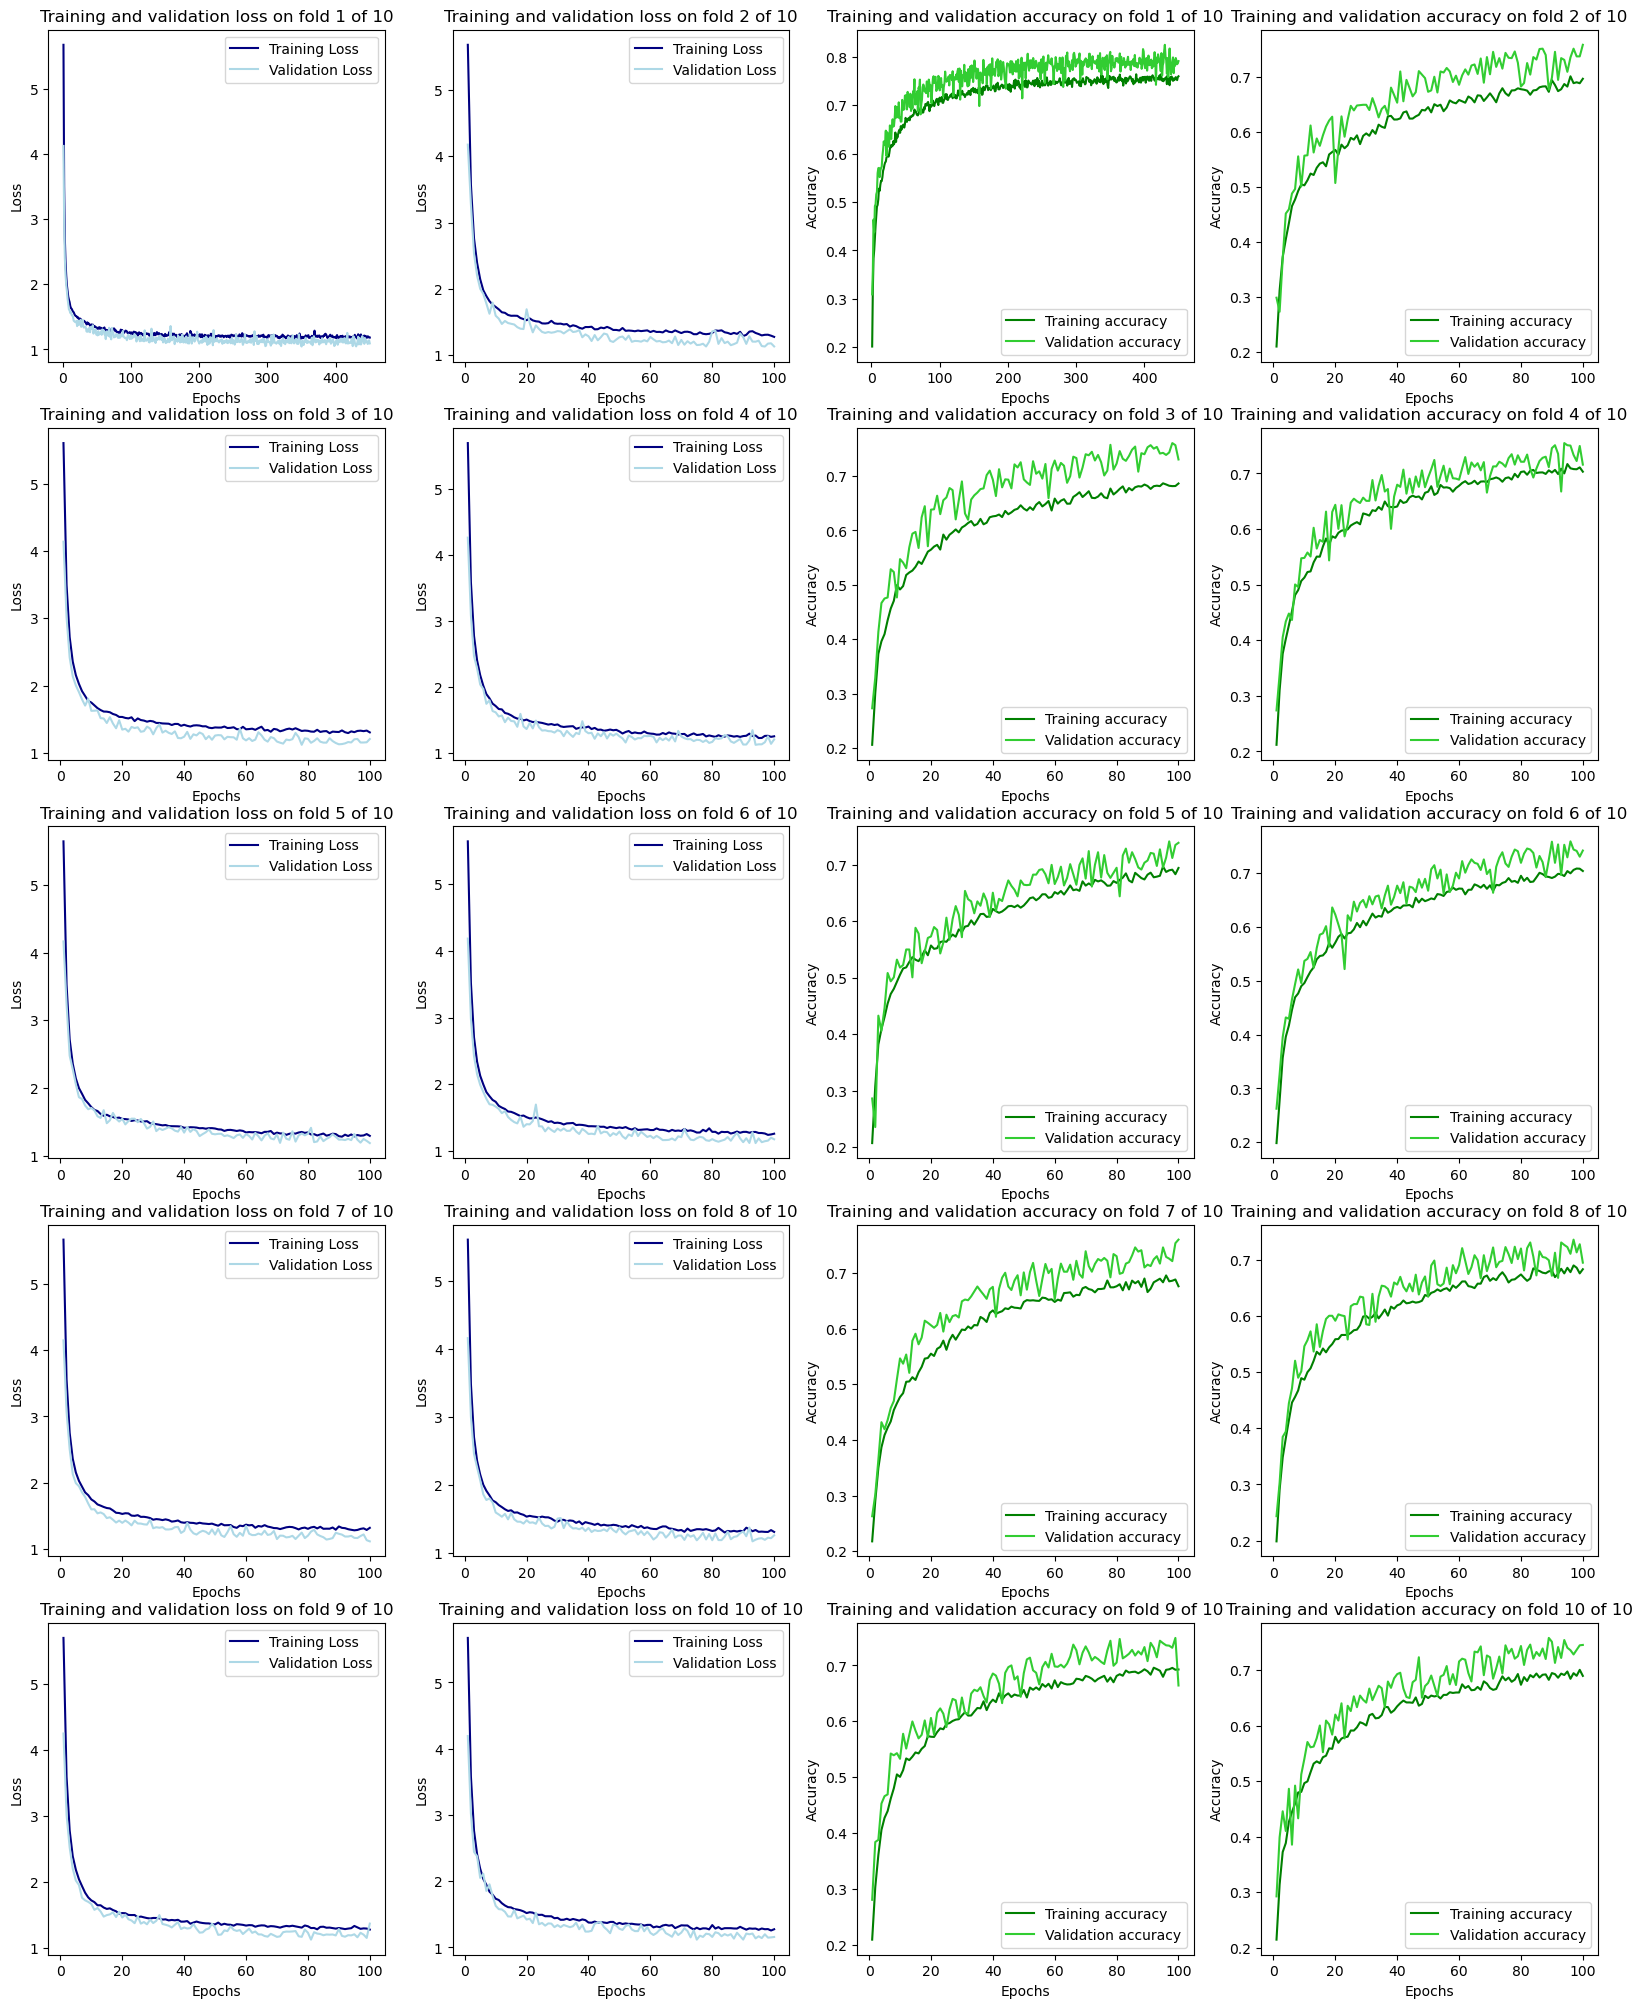

In [13]:
epochs = range(1, 101)

fig, ax = plt.subplots(5,4,figsize=(20,2.5*len(results)))

line = 0
for i in range(0,len(results), 2):
    
    epochs1 = results[i].get('num_epochs')
    epochs1 = list(range(1,epochs1+1))
    train_loss_values1=results[i].get('train_loss')
    train_acc_values1=results[i].get('train_accuracy')
    val_loss_values1 = results[i].get('val_loss')
    val_acc_values1 = results[i].get('val_accuracy')

    epochs2 = results[i+1].get('num_epochs')
    epochs2 = list(range(1,epochs2+1))
    train_loss_values2=results[i+1].get('train_loss')
    train_acc_values2=results[i+1].get('train_accuracy')
    val_loss_values2 = results[i+1].get('val_loss')
    val_acc_values2 = results[i+1].get('val_accuracy')

    ax[line,0].plot(epochs1,train_loss_values1, color='navy', linestyle='-',label='Training Loss')
    ax[line,0].plot(epochs1,val_loss_values1,color='lightblue', linestyle='-', label='Validation Loss')
    ax[line,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[line,0].set_xlabel('Epochs')
    ax[line,0].set_ylabel('Loss')
    ax[line,0].legend()

    ax[line,1].plot(epochs2,train_loss_values2,color='navy', linestyle='-',label='Training Loss')
    ax[line,1].plot(epochs2,val_loss_values2,color='lightblue', linestyle='-', label='Validation Loss')
    ax[line,1].set_title('Training and validation loss on fold '+str(i+2)+' of 10')
    ax[line,1].set_xlabel('Epochs')
    ax[line,1].set_ylabel('Loss')
    ax[line,1].legend()
    
    ax[line,2].plot(epochs1,train_acc_values1,color='green', linestyle='-', label='Training accuracy')
    ax[line,2].plot(epochs1,val_acc_values1,color='limegreen', linestyle='-', label='Validation accuracy')
    ax[line,2].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[line,2].set_xlabel('Epochs')
    ax[line,2].set_ylabel('Accuracy')
    ax[line,2].legend()
    
    ax[line,3].plot(epochs2,train_acc_values2,color='green', linestyle='-', label='Training accuracy')
    ax[line,3].plot(epochs2,val_acc_values2,color='limegreen', linestyle='-', label='Validation accuracy')
    ax[line,3].set_title('Training and validation accuracy on fold '+str(i+2)+' of 10')
    ax[line,3].set_xlabel('Epochs')
    ax[line,3].set_ylabel('Accuracy')
    ax[line,3].legend()

    line += 1

plt.show()

Estes gráficos representam a evolução da loss (azuis) e accuracy (verdes) nos sets de treino (escuros) e validação (claros).

Podemos analisar que, para todos os folds, enquanto se dá um **decréscimo da training loss ao longo das epochs, o mesmo acontece com o validation loss.**<br>
Esta tendência mostra que o nosso modelo está a aprender bem e a generalizar corretamente. Ótimo!

Quanto à accuracy, vê-se que, **com a passagem das epochs, quer a training accuracy como a validation accuracy aumentam.** Tem-se, portanto, uma aprendizagem consistente com um bom fit!

###### 

###### &emsp;&emsp;&emsp;&emsp;Número de Epochs e Tempo de Treino, Testing Accuracy

In [14]:
tempos_lst=[]
epochs_lst = []
accuracies_lst=[]

for i in range(0, len(results)):
    tempos_lst.append(results[i].get('time'))
    epochs_lst.append(results[i].get('num_epochs'))
    accuracies_lst.append(results[i].get('test_accuracy'))

print("\nTempo:")
print(f"Max - {round(max(tempos_lst),2)} segundos na fold {np.argmax(tempos_lst)+1}")
print(f"Min - {round(min(tempos_lst),2)} segundos na fold {np.argmin(tempos_lst)+1}")

print("\nAccuracy:")
print(f"Max - {round(max(accuracies_lst)*100,2)} na fold {np.argmax(accuracies_lst)+1}")
print(f"Min - {round(min(accuracies_lst)*100,2)} na fold {np.argmin(accuracies_lst)+1}")

visao_geral_fold = {
    ' ': ['Fold1', 'Fold2', 'Fold3', 'Fold4',' Fold5', 'Fold6', 'Fold7', 'Fold8', 'Fold9', 'Fold10'],
    'Epochs':[epochs_lst[0], epochs_lst[1], epochs_lst[2], epochs_lst[3], epochs_lst[4], epochs_lst[5], epochs_lst[6], epochs_lst[7], epochs_lst[8], epochs_lst[9]],
    'Training Time (s)': [tempos_lst[0], tempos_lst[1], tempos_lst[2], tempos_lst[3], tempos_lst[4], tempos_lst[5], tempos_lst[6], tempos_lst[7], tempos_lst[8], tempos_lst[9]],
    'Testing Accuracy (%)': [accuracies_lst[0]*100, accuracies_lst[1]*100, accuracies_lst[2]*100, accuracies_lst[3]*100, accuracies_lst[4]*100, accuracies_lst[5]*100, accuracies_lst[6]*100, accuracies_lst[7]*100, accuracies_lst[8]*100, accuracies_lst[9]*100]
}

df = pd.DataFrame(visao_geral_fold)
df


Tempo:
Max - 1937.48 segundos na fold 1
Min - 203.7 segundos na fold 4

Accuracy:
Max - 59.68 na fold 8
Min - 42.53 na fold 6


,,Epochs,Training Time (s),Testing Accuracy (%)
0,Fold1,450,1937.478791,50.057274
1,Fold2,100,483.314666,49.549550
2,Fold3,100,209.223941,48.756757
3,Fold4,100,203.695930,48.282829
4,Fold5,100,204.382340,58.226496
5,Fold6,100,210.317482,42.527339
6,Fold7,100,207.688876,50.119334
7,Fold8,100,211.703983,59.677422
8,Fold9,100,212.187872,47.426471
9,Fold10,100,207.576380,54.241335


Nesta tabela podemos ver que a **maior parte das folds tem o seu treino parado após 100 epochs**, sendo a excepção a fold 1 (450 epochs).<br>
**Este fenómeno verificou-se em todas as versões dos nossos modelos**, e com diferentes níveis de paciência do early stopper (10, 20 e 50). Pensamos que se deva a uma maior learning curve do fold 1 (é mencionado em várias fontes que este fold costuma ter piores resultados).

Concluímos que o **tempo de treino é diretamente proporcional ao número de epochs**, sendo o tempo/epoch aproximadamente o mesmo para todas as folds!

Quanto à testing accuracy, não podemos afirmar que esta aumenta com o número de epochs. Vemos que **a fold com mais epochs (fold 1, com 450 epochs) não é a com melhor testing accuracy**; essa seria a fold 8, com quase 60% de testing accuracy. É importante notar que esta fold foi, consistentemente em todos os nossos modelos, a fold com accuracy mais alta.<br>
Torna-se **difícil achar uma correlação entre estes resultados**, mas podemos verificar que testing accuracy varia bastante entre diferentes folds (como seria de esperar).

###### 

###### &emsp;&emsp;&emsp;&emsp; Confusion Matrixes

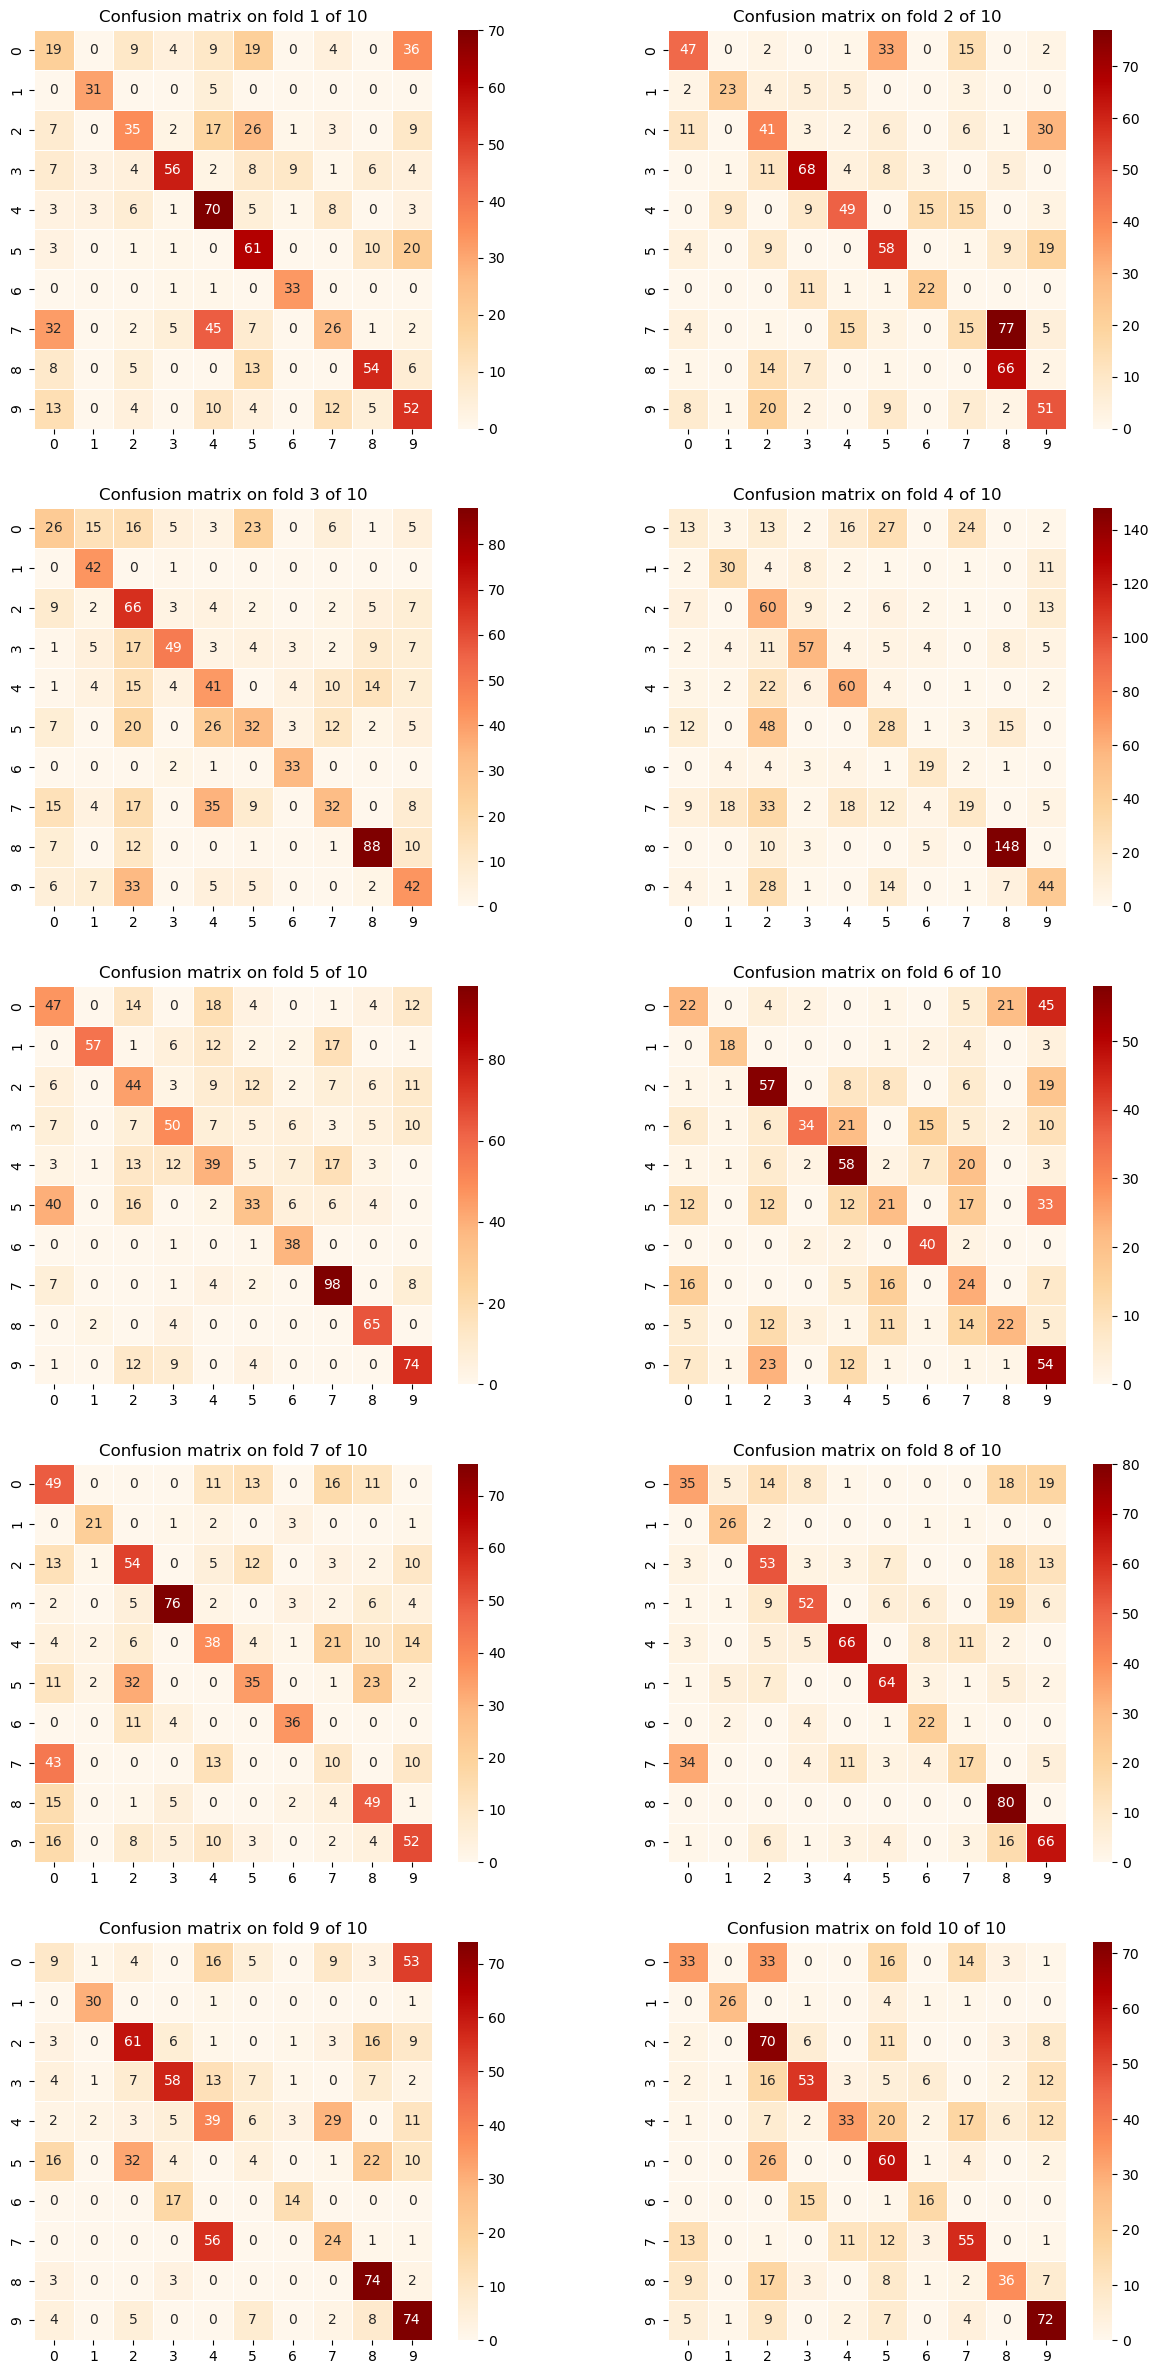

In [15]:
import seaborn as sns

fig, ax =plt.subplots(5, 2, figsize=(15,3*len(results)))

for i in range(0,len(results)):
    cm = results[i].get('confusion_matrix')
    ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'OrRd', ax=ax[i//2,i%2])

plt.show()


A existência de 10 folds torna **difícil a análise individual de cada confusion matrix.**<br>
De qualquer modo, é visível que, para cada fold, as classes com melhor taxa de previsão variam bastante! Veremos o resultado final da confusion matrix futuramente, que nos permitirá tirar conclusões mais acertadas.

### 

### Modelo Global

###### &emsp;&emsp;&emsp;&emsp;Training Time, Accuracy e Standard Deviation de Train, Validation e Test

In [16]:
print(f"Tempo total de treino = {round(np.sum(tempos_lst),2)} segundos")
print(f"Tempo médio de treino por fold = {round(np.mean(tempos_lst),2)} segundos")

train_lst = []
val_lst = []
test_lst = []

for i in results:
    train_lst.append(max(i.get('train_accuracy')))  
    val_lst.append(max(i.get('val_accuracy')))     
    test_lst.append(i.get('test_accuracy'))        


avg_train_acc = np.mean(train_lst)
std_train_acc = np.std(train_lst)
avg_val_acc = np.mean(val_lst)
std_val_acc = np.std(val_lst)
avg_test_acc = np.mean(test_lst)
std_test_acc = np.std(test_lst)


table_data = {
    ' ': ['Training', 'Validation', 'Test'],
    'Accuracy (%)': [
        round(avg_train_acc * 100, 2),  
        round(avg_val_acc * 100, 2),
        round(avg_test_acc * 100, 2)
    ],
    'Standard Deviation (%)': [
        round(std_train_acc * 100, 2),  
        round(std_val_acc * 100, 2),
        round(std_test_acc * 100, 2)
    ]
}


df = pd.DataFrame(table_data)
df

Tempo total de treino = 4087.57 segundos
Tempo médio de treino por fold = 408.76 segundos


,,Accuracy (%),Standard Deviation (%)
0,Training,70.56,2.12
1,Validation,76.02,2.30
2,Test,50.89,4.89


O nosso modelo teve um **tempo de treino total de aproximadamente 70 minutos**, demorando, em média, 7 minutos por fold.

Como resultado de **test accuracy final temos 50.89%**, com 4.89% de standard deviation.<br>
Tendo em conta as **limitações deste modelo**, e a **complexidade da tarefa em questão**, achamos que este valor é bastante positivo, e estamos contentes com este resultado! :)

###### 

###### &emsp;&emsp;&emsp;&emsp;Confusion Matrix

<AxesSubplot:title={'center':'Confusion matrix: Sum of all folds'}>

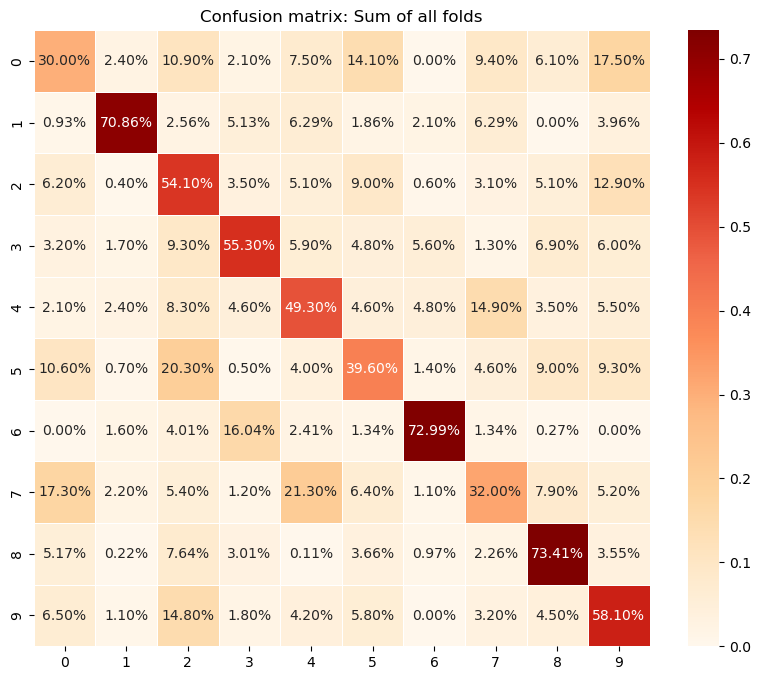

In [17]:
cm = np.zeros(shape=(10,10))
for i in results:
    cm += i.get('confusion_matrix')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax =plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Confusion matrix: Sum of all folds')
ax.invert_yaxis()
sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'OrRd', ax=ax)


Por fim, temos a confusion matrix de todas as folds juntas.

Como balanço geral temos um total de **6 classes com previsão correta superior a 50%** (classe 1 "car_horn", classe 2 "children_playing", classe 3 "dog_bark", classe 6 "gun_shot", classe 8 "siren", classe 9 "street_music") e **4 classes com previsão correta inferior a 50%** (classe 0 "air_conditioner", classe 4 "drilling" classe 5 "engine_idling", classe 7 "jackhammer").

A classe com **melhor taxa de previsão correta é a classe 8 "siren" (73.41%)**, seguida da classe 6 "gun_shot" (72.99%); ambos valores muito próximos.<br>
Como classe com **pior taxa de previsão correta temos a classe 0 "air_conditioner" (30.00%)**, seguida da classe 7 "jackhammer" (32%); valores também próximos.

Resultados longe de perfeitos, mas bastante satisfatórios!

# 

# 6. Conclusões e Notas

Após a análise de todas as métricas do nosso modelo, revela-se um padrão um pouco óbvio.<br>

O nosso modelo tem uma **grande dificuldade em classificar audios ruidosos** (air_conditioner, drilling, engine_idling, jackhammer).<br>
O audio destas classes um ruido constante, facilmente confundido até pelo ouvido do ser humano.<br>
Muitas vezes o nosso modelo classifica estas classes como uma outra igualmente ruidosa. Por exemplo, vemos que muitas vezes o modelo classifica a classe 0 "air_conditioner" como a classe 5 "engine_indling", e vice- versa.

Por outro lado, o nosso modelo tem **facilidade em classificar audios com características únicas** (car_horn, children_playing, dog_bark, gun_shot, siren, street_music).<br>
Por exemplo, a classe 6 "gun_shot" é um audio com apenas um momento de barulho muito intenso seguido de silencio, sem ruido. Esta características torna esta classe facilmente distinguível. Um outro exemplo seria a classe 8 "siren", que é um audio com um 'tempo' definidio, isto é, a sirene forma um padrão sonoro muito facilmente distinguível, facilitando a sua classificação.

Esta observação é comprovada pela repetição do treino do modelo, que obteve sempre resultados semelhantes.

Será importante notar que o teste de várias versões deste modelo, com diferentes early stoppers, regularizadores de pesos, inputs, e outras varáveis, mostrou **melhorias apenas até um certo nível.**<br>
Mesmo com o aumento da sua complexidade, a accuracy do modelo não sofria aumentos significativos, pelo que temos esta como a versão final deste modelo.

Como conclusão final, podemos afirmar que, embora o modelo cometa erros, encontrámos a justificação para a sua ocorrência, e é bastante compreensível.<br>
Achamos que o nosso modelo é um classificador suficiente para este dataset, que dificilmente mostrará melhores resultados, mesmo que seja mais elaborado

A nossa resposta a este problema de "estagnação de performance" será, portanto, o desenvolvimento de um modelo CNN, que esperamos ter uma performance superior a este!